In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import altair as alt

from path_explain.path_explainer_tf import PathExplainerTF
from plot.scatter import scatter_plot

In [5]:
n = 3000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + np.random.randn(n)

In [6]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


In [9]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [10]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 479 samples, validate on 1921 samples
Epoch 1/20
479/479 - 1s - loss: 2.6421 - val_loss: 1.1099
Epoch 2/20
479/479 - 0s - loss: 1.0052 - val_loss: 1.0625
Epoch 3/20
479/479 - 0s - loss: 0.9958 - val_loss: 1.2052
Epoch 4/20
479/479 - 0s - loss: 1.0944 - val_loss: 1.0867
Epoch 5/20
479/479 - 0s - loss: 1.0196 - val_loss: 1.2285
Epoch 6/20
479/479 - 0s - loss: 0.9160 - val_loss: 1.0985
Epoch 7/20
479/479 - 0s - loss: 0.9077 - val_loss: 1.5090
Epoch 8/20
479/479 - 0s - loss: 1.0358 - val_loss: 1.1631
Epoch 9/20
479/479 - 0s - loss: 0.9158 - val_loss: 1.2294
Epoch 10/20
479/479 - 0s - loss: 0.9898 - val_loss: 1.0161
Epoch 11/20
479/479 - 0s - loss: 0.8768 - val_loss: 1.0167
Epoch 12/20
479/479 - 0s - loss: 0.8750 - val_loss: 1.0630
Epoch 13/20
479/479 - 0s - loss: 0.9170 - val_loss: 1.1453
Epoch 14/20
479/479 - 0s - loss: 1.0659 - val_loss: 1.0903
Epoch 15/20
479/479 - 0s - loss: 0.9478 - val_loss: 1.0563
Epoch 16/20
479/479 - 0s - loss: 0.8954 - val_loss: 1.0698
Epoch 17/20
479/47

In [11]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

600/1 - 0s - loss: 0.9071


1.0366294384002686

In [12]:
y_test_pred = model.predict(X_test, batch_size=50)

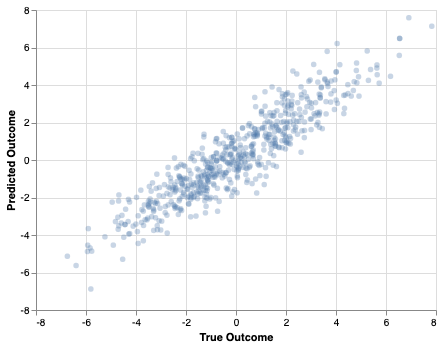

In [13]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})
alt.Chart(df).mark_point(filled=True, opacity=0.3).encode(
    alt.X('True Outcome:Q'),
    alt.Y('Predicted Outcome:Q')
)

In [14]:
explainer = PathExplainerTF(model)

In [15]:
attributions = explainer.attributions(X_test, X_train,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(X_test),
                     verbose=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 600/600 [00:02<00:00, 270.43it/s]


In [16]:
interactions = explainer.interactions(X_test, X_train,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(X_test),
                     verbose=True, interaction_index=None)

100%|██████████| 600/600 [01:22<00:00,  7.31it/s]


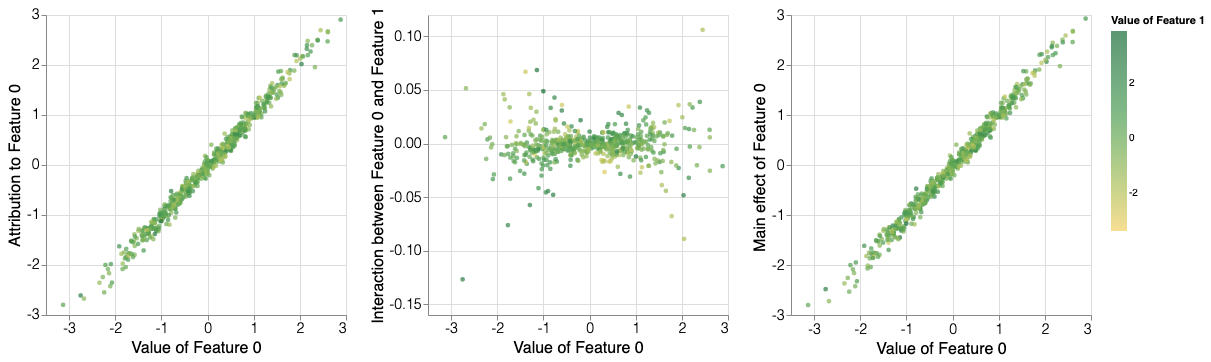

In [18]:
scatter_plot(attributions,
             X_test,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)